In [1]:
# Use seaborn for pairplot
!pip install -q seaborn

# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.2.0-rc3


In [0]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [5]:
datapath = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
datapath

32768/30286 [================================] - 0s 4us/step


'/root/.keras/datasets/auto-mpg.data'

In [6]:
columnnames = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
rawdata = pd.read_csv(datapath, names=columnnames,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = rawdata.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [0]:
dataset = dataset.dropna()

In [0]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [10]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [0]:
traindata = dataset.sample(frac=0.8,random_state=0)
testdata = dataset.drop(traindata.index)

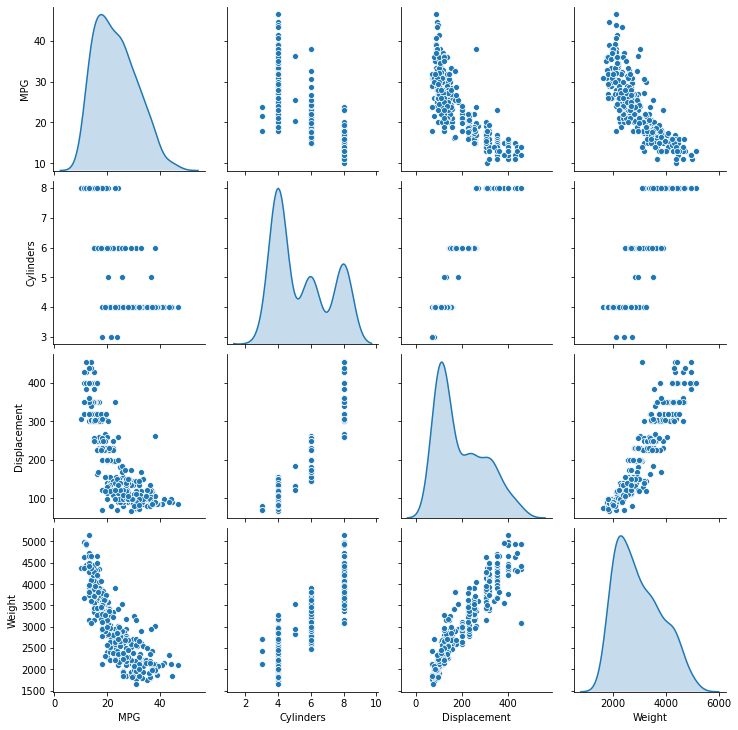

In [13]:
sns.pairplot(traindata[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [14]:
trainstats = traindata.describe()
trainstats.pop("MPG")
trainstats = trainstats.transpose()
trainstats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [0]:
trainlabels = traindata.pop('MPG')
testlabels = testdata.pop('MPG')

In [0]:
def norm(x):
  return (x - trainstats['mean']) / trainstats['std']
normedtraindata = norm(traindata)
normedtestdata = norm(testdata)

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(traindata.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [0]:
mm = build_model()

In [23]:
mm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [24]:
egbatch = normedtraindata[:10]
egresult = mm.predict(egbatch)
egresult

array([[-0.5029749 ],
       [-0.31254104],
       [-0.7885786 ],
       [-0.34746528],
       [-0.17769943],
       [-0.15168093],
       [-0.17077777],
       [-0.49508515],
       [-0.30763465],
       [-0.31592923]], dtype=float32)

In [25]:
EPOCHS = 1000

history = mm.fit(
  normedtraindata, trainlabels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:585.6215,  mae:22.9798,  mse:585.2531,  val_loss:578.0153,  val_mae:22.7973,  val_mse:578.2848,  
....................................................................................................
Epoch: 100, loss:6.0414,  mae:1.7123,  mse:6.0240,  val_loss:9.2206,  val_mae:2.3725,  val_mse:9.2039,  
....................................................................................................
Epoch: 200, loss:5.3344,  mae:1.5288,  mse:5.3286,  val_loss:9.3448,  val_mae:2.2460,  val_mse:9.3447,  
....................................................................................................
Epoch: 300, loss:5.3926,  mae:1.5630,  mse:5.3350,  val_loss:9.5585,  val_mae:2.3565,  val_mse:9.5504,  
....................................................................................................
Epoch: 400, loss:4.8529,  mae:1.5032,  mse:4.8312,  val_loss:9.8269,  val_mae:2.4182,  val_mse:9.8106,  
..............................................................

In [26]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.971755,1.102422,2.974424,11.231647,2.552617,11.217102,995
996,3.244812,1.161674,3.252205,10.739149,2.491026,10.716036,996
997,2.958598,1.103054,2.947764,10.614727,2.520383,10.588206,997
998,3.104618,1.134902,3.123632,11.181845,2.550338,11.160085,998
999,3.163190,1.159596,3.189158,10.889553,2.501130,10.866935,999


In [0]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

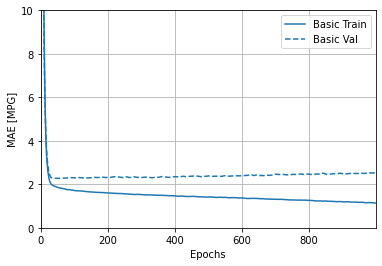

In [28]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

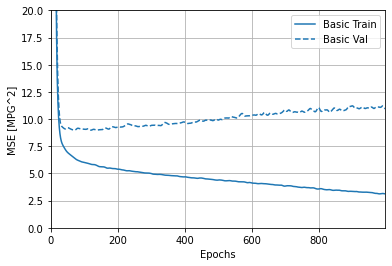

In [29]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

In [31]:
mm = build_model()

# The patience parameter is the amount of epochs to check for improvement
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

earlyhistory = mm.fit(normedtraindata, trainlabels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[earlystop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:558.6964,  mae:22.4239,  mse:560.1786,  val_loss:545.7257,  val_mae:22.0795,  val_mse:546.0094,  
.....................................................................................

Text(0, 0.5, 'MAE [MPG]')

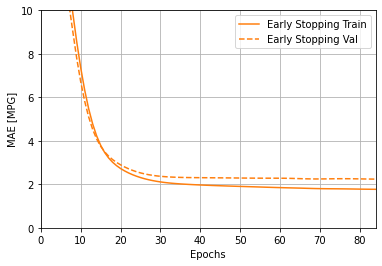

In [32]:
plotter.plot({'Early Stopping': earlyhistory}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [33]:
loss, mae, mse = mm.evaluate(normedtestdata, testlabels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.6485 - mae: 1.7595 - mse: 5.3882
Testing set Mean Abs Error:  1.76 MPG


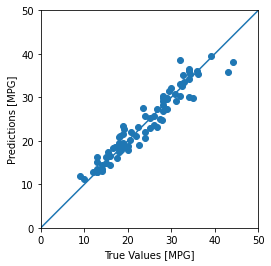

In [34]:
testpredictions = mm.predict(normedtestdata).flatten()

a = plt.axes(aspect='equal')
plt.scatter(testlabels, testpredictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


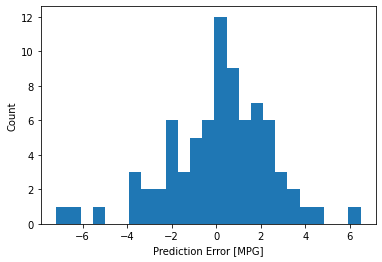

In [35]:
error = testpredictions - testlabels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")